### Importing Relevant Packages

In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Loading Data and Preprocessing

In [3]:
raw_data = yfinance.download(tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = '1994-01-07', end = '2019-09-01', 
                              interval = '1d', group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [4]:
df_comp = raw_data.copy()

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']

In [7]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

### Creating Returns

In [8]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.spx.pct_change(1).mul(100)

### Normalizing

In [ ]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp[1]) * 100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp[1]) * 100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp[1]) * 100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp[1]) * 100

### Splitting the Data

In [9]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting

In [22]:
start_date = '2014-07-15'
end_date = '2015-01-01'
model_garch = arch_model(df_comp.ret_ftse[1:], vol = 'GARCH', p = 1, q = 1, mean = 'AR', dist = 'Normal')
res_garch = model_garch.fit(last_obs = start_date, update_freq = 10)
#Last_obs = last date of the training dataset
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7310.187356080805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7310.187341157476
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


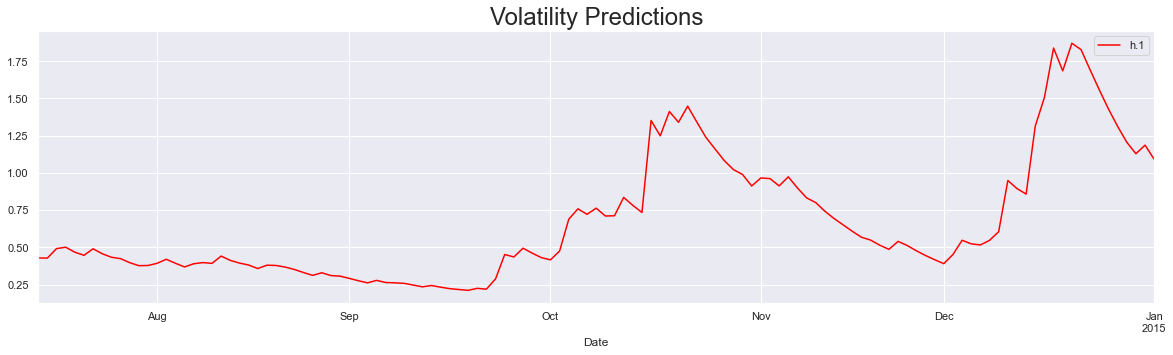

In [23]:
pred_garch.residual_variance[start_date:end_date].plot(figsize = (20,5), color = 'red')
plt.title('Volatility Predictions', size = 24)
plt.show()

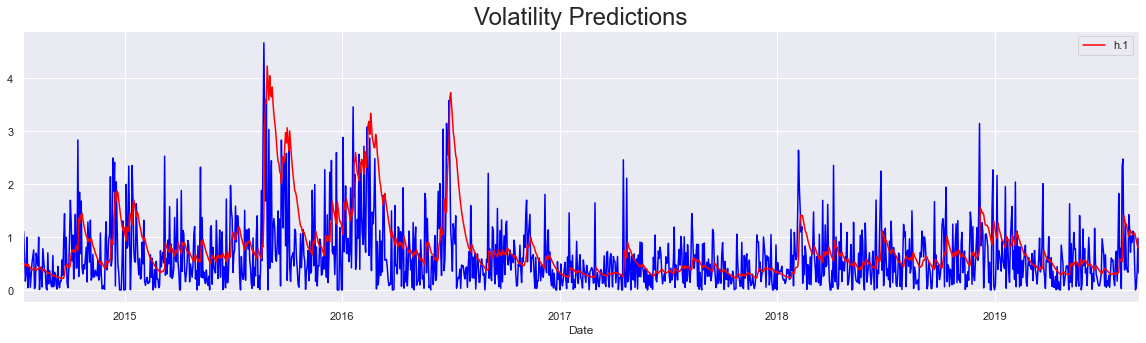

In [24]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = 'red', zorder = 2)
df_test.ret_ftse.abs().plot(color = 'blue', zorder = 1)
plt.title('Volatility Predictions', size = 24)
plt.show()

In [25]:
#Many-step ahead predictions for a single day
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811472,0.805697,0.86732,0.940727,1.020889,1.08517,1.074223,1.067983,1.081403,1.090846,...,0.837754,0.839355,0.830751,0.81593,0.827564,0.839795,0.851102,0.864614,0.872177,0.886642
